# Rigorous estimates of p-laplacian's first eigenvalue using interval arithmetic

In [6]:
using DifferentialEquations
using Plots; gr()
using IntervalArithmetic
using LinearAlgebra
using LaTeXStrings

In [7]:
"""
Vypočítá numerické řešení p-laplaciánu.

Vstupní parametry:
λi ... interval na kterém hledám λ₁
P ... p z p-laplaciánu
n ... počet kroků dělení

Výstupní hodnoty:
t, tᴵ ... body dělení (Float64, Interval) časové osy
U₁, U₁ᴵ  ... bodové a intervalové hodnoty řešení u₁ v t
U₂, U₂ᴵ ... intervalové a bodové řešení u2
Λ₁ ... numerický odhad λ₁
"""
function plaplace_solve(λi, p, n; plt_res=true, u2_0=1.0)
   
    function sl(du,u,P,t) # parametr p je odhad na λ₁ a p z p-laplacianu
        λ, p = P
        du[1] = abs(u[2])^(1/(p-1)) * sign(u[2])
        du[2] = -λ * abs(u[1])^(p-1)*sign(u[1]) 
    end

    u0 = [0.0; u2_0;] # počáteční podmínka
    a, b = λi
    Λ₁ = (a + b)/2
    Δt = 1.0/(n-1) # velikost intervalu dělení
    e = 1e-12 # zastavovací podmínka

    while (b-a) >= e
        prob = ODEProblem(sl, u0, (0.0, 1.0), (Λ₁, p))
        sol = solve(prob, saveat=Δt, abstol=1e-8,reltol=1e-8)
        if sol(1)[1] == 0 # hodnota u₁ v t=1
            break
        else
            probA = ODEProblem(sl, u0, (0.0, 1.0), (a, p))
            solA = solve(probA, saveat=Δt, abstol=1e-8,reltol=1e-8)
            probS = ODEProblem(sl, u0, (0.0, 1.0), (Λ₁, p))
            solS = solve(probS, saveat=Δt, abstol=1e-8,reltol=1e-8)
            if solA(1)[1] * solS(1)[1] < 0
                b = Λ₁
            else
                a = Λ₁
            end
            Λ₁ = (a+b)/2
        end
    end

    prob = ODEProblem(sl, u0, (0.0, 1.0), (Λ₁, p))
    sol = solve(prob, saveat=Δt, abstol=1e-8,reltol=1e-8)

    if plt_res
        println("Numericky získané první vlastní číslo Λ₁=$(Λ₁)")
        display(plot(sol,marker=2))
    end
    
    t = sol.t
    tᴵ = [@interval(i) for i in t]
    U₁ = [u[1] for u in sol.u]
    U₁[end] = 0
    U₁ᴵ = [@interval(u[1]) for u in sol.u]
    U₁ᴵ[end] = 0..0
    U₂ = [u[2] for u in sol.u]
    U₂ᴵ = [@interval(u[2]) for u in sol.u]
    
    return t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁
end;

In [8]:
"""
Intervalově zadané řídící body proloží intervalově kubickým splinem.

Vstupní parametry:
t, tᴵ         ... bodové a intervalové dělení časové osy
U, Uᴵ         ... body a intervaly které prokláme splinem
Uₗd2, Uᵣd2    ... hodnoty druhé derivace v krajních (levý, pravý) bodech
plt_res=true  ... vykreslení řešení
ns=10         ... dělení jednotlivých oblouků kubického splinu

Výstupní hodnoty:
csc_u ... koeficienty kubického splinu
Uˢ   ... intervalové hodnoty splinu v bodech dělení
"""
function cubic_natural_spline(t, tᴵ, U, Uᴵ, Uₗd2, Uᵣd2; plt_res=true, ns=10)
    #matice A
    n=length(Uᴵ)
    dv = [4..4 for i in 1:n-2]
    ev = [1..1 for i in 1:n-3]
    A = Array(SymTridiagonal(dv,ev))
    A⁻¹ = inv(A)

    #pravá strana
    h = 1.0/(n-1)
    rhs = []
    for i in 3:length(Uᴵ)
        append!(rhs, 6/h^2 * (Uᴵ[i] - 2 * Uᴵ[i-1] + Uᴵ[i-2]))
    end
    
    rhs[1] = rhs[1]-Uₗd2
    rhs[end] = rhs[end]-Uᵣd2    

    # vektor druhých derivací  
    Ud2 = []
    append!(Ud2, @interval(Uₗd2))
    append!(Ud2, A⁻¹*rhs)
    append!(Ud2, @interval(Uᵣd2))

    # koeficienty jednotlivých oblouků splinu
    csc_U = []
    for i in 1:length(Uᴵ)-1
        a=b=c=d=0
        a = (Ud2[i+1]-Ud2[i])/(6*h)
        b = Ud2[i]/2 
        c = (Uᴵ[i+1] - Uᴵ[i])/h - h*(2*Ud2[i]+Ud2[i+1])/6
        d = Uᴵ[i]
        append!(csc_U, [[a,b,c,d]])
    end 
    

    if plt_res
        res_plot = plot(t, U, marker=2)
    end
    Uˢ = Interval[] # intervalově vyjádřený spline 
    for i in 1:length(Uᴵ)-1
        x_dom = t[i]..t[i+1]
        x_int = mince(x_dom,ns)
        f(x) = csc_U[i][1]*(x-t[i])^3 + csc_U[i][2]*(x-t[i])^2 + csc_U[i][3]*(x-t[i]) + csc_U[i][4]
        append!(Uˢ, f.(x_int))
        if plt_res
            boxes = IntervalBox.(x_int, f.(x_int))    
            plot!(boxes, legend=false)
        end
    end
    if plt_res display(res_plot) end
        
    return csc_U, Uˢ
end;

In [121]:
"""
Intervalově zadané řídící body proloží intervalově kubickým splinem.

Vstupní parametry:
t, tᴵ         ... bodové a intervalové dělení časové osy
U, Uᴵ         ... body a intervaly které prokláme splinem
Uₗd1, Uᵣd1     ... hodnoty první derivace v krajních (levý, pravý) bodech
plt_res=true  ... vykreslení řešení
ns=10         ... dělení jednotlivých oblouků kubického splinu

Výstupní hodnoty:
csc_u ... koeficienty kubického splinu
Uˢ   ... intervalové hodnoty splinu v bodech dělení
"""
function cubic_end_slope_spline(t, tᴵ, U, Uᴵ, Uₗd1, Uᵣd1; plt_res=true, ns=10)
    #matice A
    n=length(Uᴵ)
    dv = [4..4 for i in 1:n-2]
    ev = [1..1 for i in 1:n-3]
    A = Array(SymTridiagonal(dv,ev))
    A[1,1] = 3.5..3.5
    A[end,end] = 3.5..3.5
    A⁻¹ = inv(A)

    #pravá strana
    h = 1.0/(n-1)
    rhs = []
    for i in 3:length(Uᴵ)
        append!(rhs, 6/h^2 * (Uᴵ[i] - 2 * Uᴵ[i-1] + Uᴵ[i-2]))
    end
    
    rhs[1] = rhs[1] - 3/h * ( (Uᴵ[2]-Uᴵ[1])/h - Uₗd1)
    rhs[end] = rhs[end] - 3/h * (Uᵣd1 - (Uᴵ[end]-Uᴵ[end-1])/h)    

    # vektor druhých derivací  
    sol = A⁻¹*rhs
    Ud2 = []
    
    σ₀ = 3/h * ( (Uᴵ[2]-Uᴵ[1])/h - Uₗd1) - sol[1]/2
    σ₁ = 3/h * (Uᵣd1 - (Uᴵ[end]-Uᴵ[end-1])/h)   - sol[end]/2
    append!(Ud2, @interval(σ₀))
    append!(Ud2, sol)
    append!(Ud2, @interval(σ₁))

    # koeficienty jednotlivých oblouků splinu
    csc_U = []
    for i in 1:length(Uᴵ)-1
        a=b=c=d=0
        a = (Ud2[i+1]-Ud2[i])/(6*h)
        b = Ud2[i]/2 
        c = (Uᴵ[i+1] - Uᴵ[i])/h - h*(2*Ud2[i]+Ud2[i+1])/6
        d = Uᴵ[i]
        append!(csc_U, [[a,b,c,d]])
    end 
    

    if plt_res
        res_plot = plot(t, U, marker=2)
    end
    Uˢ = Interval[] # intervalově vyjádřený spline 
    for i in 1:length(Uᴵ)-1
        x_dom = t[i]..t[i+1]
        x_int = mince(x_dom,ns)
        ### polynom
        #f(x) = csc_U[i][1]*(x-t[i])^3 + csc_U[i][2]*(x-t[i])^2 + csc_U[i][3]*(x-t[i]) + csc_U[i][4]
        ### horner
        f(x) = csc_U[i][4] + (x-t[i])*(csc_U[i][3] + (x-t[i])*(csc_U[i][2] + csc_U[i][1]*(x-t[i])))
        append!(Uˢ, f.(x_int))
        if plt_res
            boxes = IntervalBox.(x_int, f.(x_int))    
            plot!(boxes, legend=false)
        end
    end
    if plt_res display(res_plot) end
        
    return csc_U, Uˢ
end;

In [19]:
"""
Z intervalově vyjádřeného splinu U₂ᴵ rekonstruuje intervalově vyjádřené U₁ˢ.

Vstupní parametry:
p             ... hodnota p z p-laplaciánu
U₂ˢ           ... intervalové hodnoty splinu u₂ v bodech dělení
t             ... bodové dělení časové osy
U₁            ... bodové numerické hodnoty u₁ 
plt_res=true  ... vykreslení řešení


Výstupní hodnoty:
U₁ˢ  ... intervalové hodnoty u₁ v bodech dělení
"""
function get_u1(p, U₂ˢ, t, U₁; plt_res=true, δ=-1.0)
    
    f(x) = abs(x)^(1/(p-1))*sign(x)
    ni = mince(0..1,length(U₂ˢ))

    U₁_tmp = Interval[0..0]
    for i in 1:length(U₂ˢ)
        append!(U₁_tmp, U₁_tmp[end] + f(U₂ˢ[i]) * diam(ni[i]))
    end
    
    U₁ˢ = Interval[]
    for i in 1:length(U₁_tmp)-1
        append!(U₁ˢ, U₁_tmp[i] ∪ U₁_tmp[i+1])
    end
    
    if δ == -1
        δ = inf(minimum(U₁ˢ))
        if δ > 0
            U₁ˢ = U₁ˢ .- (δ - δ*1e-8)
        else
            U₁ˢ = U₁ˢ .+ (-δ - δ*1e-8)
        end
        #@show δ - δ*1e-8
    else
        U₁ˢ  = U₁ˢ .+ δ
    end

    if plt_res
        x_int = mince(0..1,length(U₁ˢ))
        boxes = IntervalBox.(x_int, U₁ˢ)
        plot(boxes)
        display(plot!(t, U₁, marker=2, legend=false))
    end
    
    return U₁ˢ, -δ - δ*1e-8
    
end;

In [124]:
"""
Z koeficientů intervalově vypočítá derivaci kubického splinu

Vstupní parametry:
csc           ... koeficienty splinu
t, tᴵ         ... bodové i intervalově dělení časové osy
ns            ... počet bodů dělení jednotlivého oblouku splinu
plt_res=true  ... vykreslení řešení


Výstupní hodnoty:
Uˢ   ... intervalové hodnoty derivace splinu

"""
function der_cubic_spline(csc, t, tᴵ, ns; plt_res = true)
    
    Uₜₘₚ = Interval[]
    csc_Uder = [ [@interval(3) * c[1], @interval(2) * c[2], c[3]] for c in csc ] 
    for i in 1:length(t)-1
        x_dom = t[i]..t[i+1] 
        x_int = mince(x_dom,ns)
        ### polynom
        #f(x) = csc_Uder[i][1]*(x-t[i])^2 + csc_Uder[i][2]*(x-t[i]) + csc_Uder[i][3]
        ### horner
        f(x) = csc_Uder[i][3] + (x-t[i])*(csc_Uder[i][2] + (x-t[i])*csc_Uder[i][1])
        append!(Uₜₘₚ, f.(x_int))
    end
    
    Uˢ = Interval[]
    for i in 1:length(Uₜₘₚ)-1
        append!(Uˢ, Uₜₘₚ[i] ∪ Uₜₘₚ[i+1])
    end
    append!(Uˢ,Uₜₘₚ[end])
    
    if plt_res
        x_int = mince(0..1,length(Uˢ))
        display(plot(IntervalBox.(x_int, Uˢ), legend=false))
    end
    
    return Uˢ
end;

In [12]:
"""
Intervalově vypočítá dolní odhad λ₁

Vstupní parametry:
numerator     ... čitatel 
denominator   ... jmenovatel
plt_res=true  ... vykreslení řešení


Výstupní hodnoty:
λ₁ˡᵒʷ    ... dolní odhad λ₁
Fˡᵒʷ     ... intervalové hodnoty funkce dolního odhadu
"""
function lower_estimate(numerator, denominator, p; plt_res=true)
    f(x,y) = -x / y^(p-1)
    λ₁ᵗᵐᵖ = f.(numerator, denominator)

    Fˡᵒʷ = Interval[]#Interval[100..100]
    for i in 1:length(λ₁ᵗᵐᵖ)-1
        append!(Fˡᵒʷ, λ₁ᵗᵐᵖ[i] ∪ λ₁ᵗᵐᵖ[i+1])
    end
    append!(Fˡᵒʷ,λ₁ᵗᵐᵖ[end])
    
    λ₁ˡᵒʷ = inf(minimum(Fˡᵒʷ))
    
    if plt_res
        println("Dolní odhad λ₁ˡᵒʷ=$λ₁ˡᵒʷ")
        boxes = IntervalBox.(mince(0..1, length(Fˡᵒʷ)), Fˡᵒʷ)
        display(plot(boxes, ylim=(λ₁ˡᵒʷ/2,3*λ₁ˡᵒʷ/2), legend=false))
    end
    
    return λ₁ˡᵒʷ, Fˡᵒʷ
end;

In [13]:
"""
Intervalově vypočítá horní odhad λ₁

Vstupní parametry:
p             ... hodnota p z p-laplaciánu
U₁ˢ           ... intervalové hodnoty U₁
U₁ˢ_der       ... intervalové hodnoty U₁' 
plt_res=true  ... vypíše řešení


Výstupní hodnoty:
λ₁ᵘᵖ    ... horní odhad λ₁
"""
function upper_estimate(p, U₁ˢ, U₁ˢ_der; plt_res=true)
    
    f(x) = abs(x)^(p)
    ni = mince(0..1,length(U₁ˢ))

    numerator = 0..0
    for i in 1:length(U₁ˢ_der)
        numerator = numerator + f(U₁ˢ_der[i]) * diam(ni[i])
    end
    
    denominator = 0..0
    for i in 1:length(U₁ˢ)
        denominator = denominator + f(U₁ˢ[i]) * diam(ni[i])
    end

    λ₁ᵘᵖ = sup(numerator/denominator)
    if plt_res
        println("Horní odhad λ₁ᵘᵖ=$λ₁ᵘᵖ")
    end

    return λ₁ᵘᵖ 
end;

## Experiments

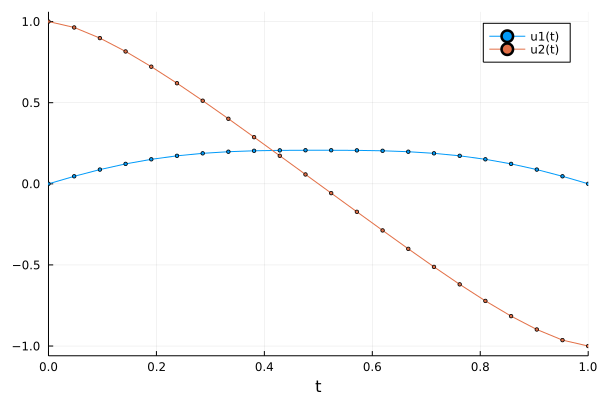

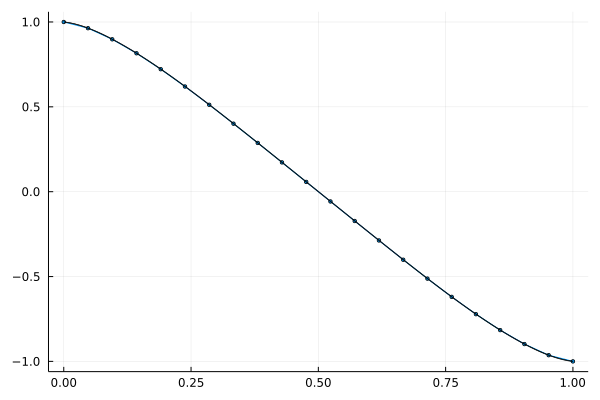

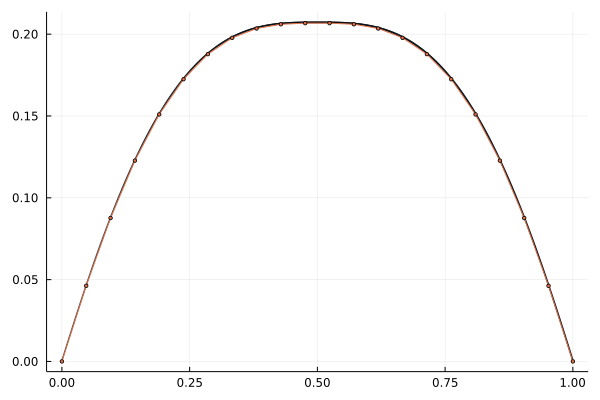

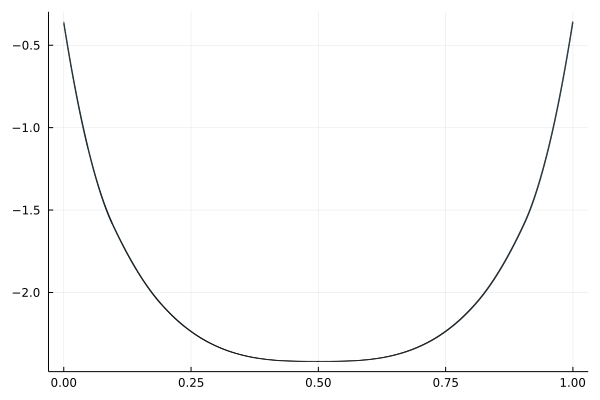

Numericky získané první vlastní číslo Λ₁=5.318718074184005


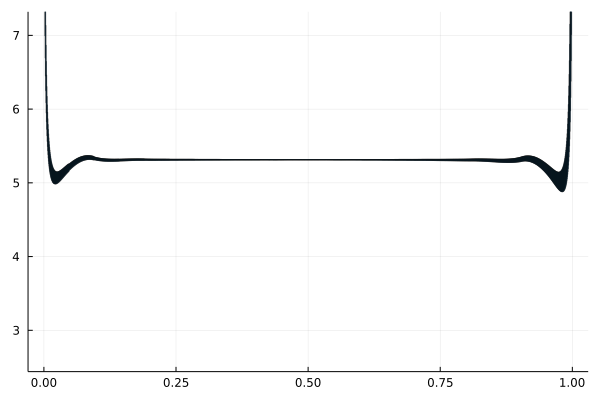

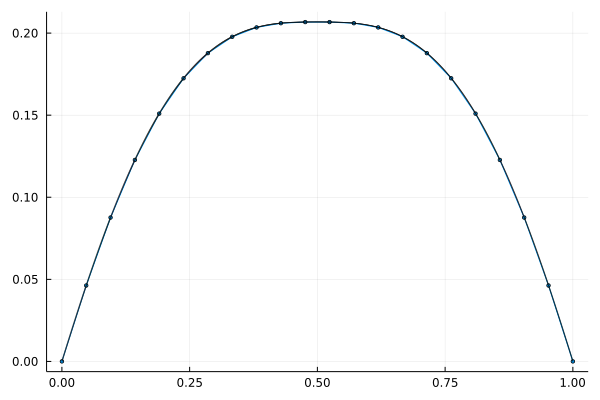

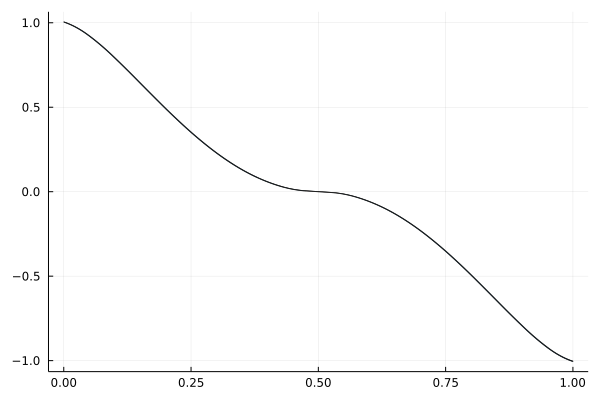

Dolní odhad λ₁ˡᵒʷ=4.8799402606279108
Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: 0.43877781575125852
Horní odhad λ₁ᵘᵖ=5.3388409814463529
Chyba horního odhadu proti přesné hodnotě λ₁ₚ: 0.020122905067183616


In [412]:
p=1.5
λ₁ = (p-1)*(2*(π/p)/(sin(π/p)))^p

n = 22 # bodů dělení 
ns = 100 # bodů dělení jednotlivého oblouku spline
si = mince(0..1,(n-1)*ns) # intervaly dělení splinu
λᵢₙᵢₜ = (3.,8.); # interval na kterém hledáme λ₁ (nesmí obsahovat vyšší λᵢ)

### lower estimate
# 1st step
t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n);

# 2nd step
#Uₗd1 = - ceil(Λ₁) * 0.000522^(p-1)
#Uᵣd1 = - ceil(Λ₁) * 0.000522^(p-1)

Uₗd1 = Uᵣd1 = -0.359

csc_U₂ˢ, U₂ˢ = cubic_end_slope_spline(t, tᴵ, U₂, U₂ᴵ, Uₗd1, Uᵣd1, ns=ns);
# 3rd step
U₁ˢ,δ = get_u1(p,U₂ˢ, t, U₁);
# 4th step
U₂ˢ_der = der_cubic_spline(csc_U₂ˢ, t, tᴵ, ns);
# 5th step
λ₁ˡᵒʷ, Fˡᵒʷ = lower_estimate(U₂ˢ_der, U₁ˢ, p)
println("Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁-λ₁ˡᵒʷ)")


### upper estimate
csc_U₁, U₁ˢ = cubic_natural_spline(t, tᴵ, U₁, U₁ᴵ, -1, -1, ns=ns);
#cubic_end_slope_spline(t, tᴵ, U₂, U₂ᴵ, Uₗd1, Uᵣd1, ns=ns);
U₁ˢ_der = der_cubic_spline(csc_U₁, t, tᴵ, ns); 
λ₁ᵘᵖ = upper_estimate(p, U₁ˢ, U₁ˢ_der, plt_res=true);
println("Chyba horního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁ᵘᵖ-λ₁)")

**Porovnání standardního vyjádření polynomu a vyjádření přes Hornerovo schéma**

Přes Hornera je chyba o malý kousek menší.

In [120]:
p=1.5
λ₁ = (p-1)*(2*(π/p)/(sin(π/p)))^p
println("Přesná hodnota λ₁ₚ=$λ₁")

n = 22
ns = 10000# 150000
si = mince(0..1,(n-1)*ns) # dělení splinu
λᵢₙᵢₜ = (3.,8.);

t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n, plt_res=false);
Uₗd1 = -0.309 # ceil(Λ₁) * 0.000522^(p-1)
Uᵣd1 = -0.309 # ceil(Λ₁) * 0.000522^(p-1)
csc_U₂, U₂ˢ = cubic_end_slope_spline(t, tᴵ, U₂, U₂ᴵ, Uₗd1, Uᵣd1, ns=ns, plt_res=false);
U₁ˢ, _ = get_u1(p,U₂ˢ, t, U₁, plt_res=false);
U₂ˢ_der = der_cubic_spline(csc_U₂, t, tᴵ, ns, plt_res=false);
λ₁ˡᵒʷ, Fˡᵒʷ = lower_estimate(U₂ˢ_der, U₁ˢ, p, plt_res=false);
println("Dolní odhad λ₁ˡᵒʷ=$λ₁ˡᵒʷ")
println("Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁-λ₁ˡᵒʷ)")

csc_U₁, U₁ˢ = cubic_natural_spline(t, tᴵ, U₁, U₁ᴵ, -1, -1, ns=ns, plt_res=false);
U₁ˢ_der = der_cubic_spline(csc_U₁, t, tᴵ, ns, plt_res=false); 
λ₁ᵘᵖ = upper_estimate(p, U₁ˢ, U₁ˢ_der, plt_res=false);
println("Horní odhad λ₁ᵘᵖ=$λ₁ᵘᵖ")
println("Chyba horního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁ᵘᵖ-λ₁)")

Přesná hodnota λ₁ₚ=5.318718076379169
Dolní odhad λ₁ˡᵒʷ=5.1298655848665984
Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: 0.18885249151257089
Horní odhad λ₁ᵘᵖ=5.3189371481139665
Chyba horního odhadu proti přesné hodnotě λ₁ₚ: 0.00021907173479718267


In [125]:
# přes hornerovo schéma

p=1.5
λ₁ = (p-1)*(2*(π/p)/(sin(π/p)))^p
println("Přesná hodnota λ₁ₚ=$λ₁")

n = 22
ns = 10000# 150000
si = mince(0..1,(n-1)*ns) # dělení splinu
λᵢₙᵢₜ = (3.,8.);

t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n, plt_res=false);
Uₗd1 = -0.309 # ceil(Λ₁) * 0.000522^(p-1)
Uᵣd1 = -0.309 # ceil(Λ₁) * 0.000522^(p-1)
csc_U₂, U₂ˢ = cubic_end_slope_spline(t, tᴵ, U₂, U₂ᴵ, Uₗd1, Uᵣd1, ns=ns, plt_res=false);
U₁ˢ, _ = get_u1(p,U₂ˢ, t, U₁, plt_res=false);
U₂ˢ_der = der_cubic_spline(csc_U₂, t, tᴵ, ns, plt_res=false);
λ₁ˡᵒʷ, Fˡᵒʷ = lower_estimate(U₂ˢ_der, U₁ˢ, p, plt_res=false);
println("Dolní odhad λ₁ˡᵒʷ=$λ₁ˡᵒʷ")
println("Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁-λ₁ˡᵒʷ)")

csc_U₁, U₁ˢ = cubic_natural_spline(t, tᴵ, U₁, U₁ᴵ, -1, -1, ns=ns, plt_res=false);
U₁ˢ_der = der_cubic_spline(csc_U₁, t, tᴵ, ns, plt_res=false); 
λ₁ᵘᵖ = upper_estimate(p, U₁ˢ, U₁ˢ_der, plt_res=false);
println("Horní odhad λ₁ᵘᵖ=$λ₁ᵘᵖ")
println("Chyba horního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁ᵘᵖ-λ₁)")

Přesná hodnota λ₁ₚ=5.318718076379169
Dolní odhad λ₁ˡᵒʷ=5.1299227193438002
Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: 0.18879535703536909
Horní odhad λ₁ᵘᵖ=5.3189331381621967
Chyba horního odhadu proti přesné hodnotě λ₁ₚ: 0.00021506178302743706


**Testy na první derivaci na krajích pro end slope spline**


|dělení oblouku| p=1.5  |   | p=3   |   |
|---|---|---|---|---|
|100   | -0.359 | $5.199\times 10^{-4}$ | -0.00559 |  $5.43\times 10^{-4}$ |
|1k   | -0.314 | $5.22\times 10^{-5}$  | -0.00045   |  $5.015\times 10^{-5}$ |
|10k   | -0.309 | $5.28\times 10^{-6}$ |  -0.0000748 |  $5.0086\times 10^{-6}$ |
|150k   | -0.3085 | $4.167\times 10^{-7}$  | -0.00001   | $1.2535\times 10^{-7}$  |

In [31]:
p=1.5
λ₁ = (p-1)*(2*(π/p)/(sin(π/p)))^p
println("Přesná hodnota λ₁ₚ=$λ₁")

n = 22
ns = 150000# 150000
si = mince(0..1,(n-1)*ns) # dělení splinu
λᵢₙᵢₜ = (3.,8.);

Ud1s = -0.31:0.00025:-0.3075

t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n, plt_res=false);
#Uₗd1 = - ceil(Λ₁) * 0.000522^(p-1)
#Uᵣd1 = - ceil(Λ₁) * 0.000522^(p-1)

posuny = []
chyby = []


for Ud1 in Ud1s 
    csc_U₂, U₂ˢ = cubic_end_slope_spline(t, tᴵ, U₂, U₂ᴵ, Ud1, Ud1, ns=ns, plt_res=false);
    U₁ˢ, posun = get_u1(p,U₂ˢ, t, U₁, plt_res=false);
    U₂ˢ_der = der_cubic_spline(csc_U₂, t, tᴵ, ns, plt_res=false);
    λ₁ˡᵒʷ, Fˡᵒʷ = lower_estimate(U₂ˢ_der, U₁ˢ, p, plt_res=false);
    append!(posuny, posun)
    append!(chyby, λ₁-λ₁ˡᵒʷ)
    #@show Ud1
    #println("Dolní odhad λ₁ˡᵒʷ=$λ₁ˡᵒʷ")
    #println("Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁-λ₁ˡᵒʷ)")
    #println("-----------------")
end

Přesná hodnota λ₁ₚ=5.318718076379169


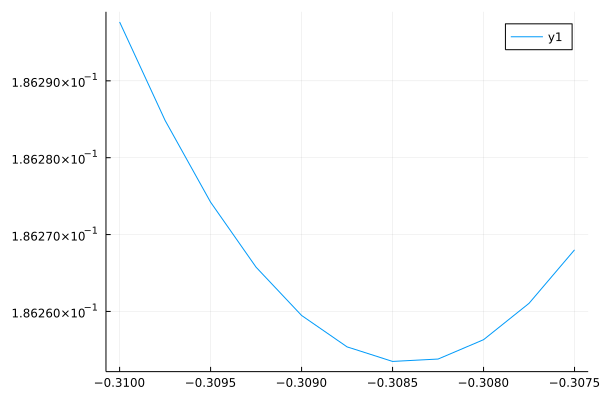

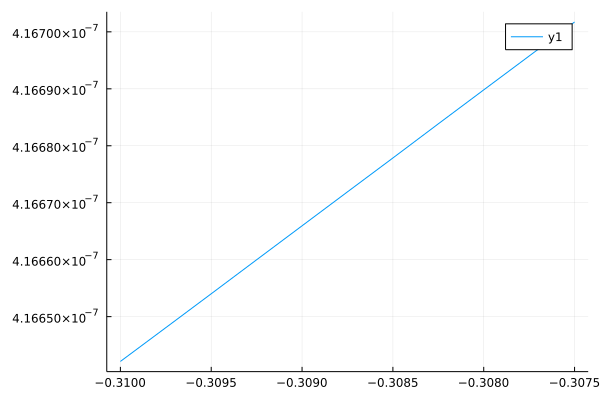

In [32]:
#Pro ns = 150000
chyby150k = chyby
display(plot(Ud1s, chyby150k))
posuny150k = posuny
plot(Ud1s, posuny150k)

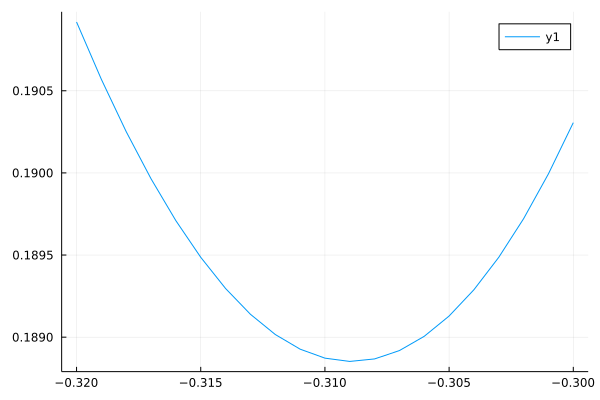

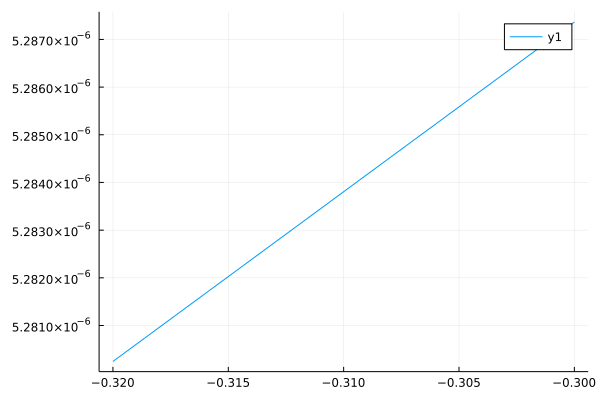

In [26]:
#Pro ns = 10000
chyby10k = chyby
display(plot(Ud1s, chyby10k))
posuny10k = posuny
plot(Ud1s, posuny10k)

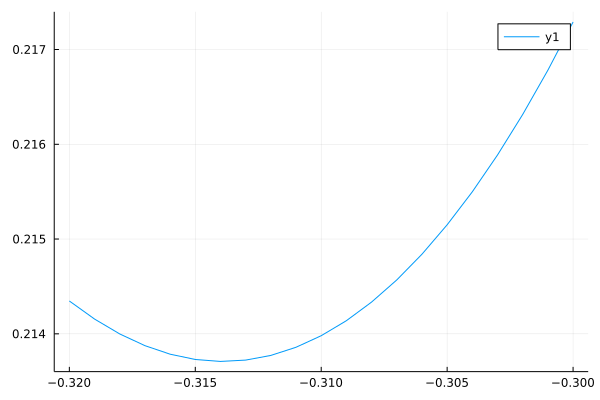

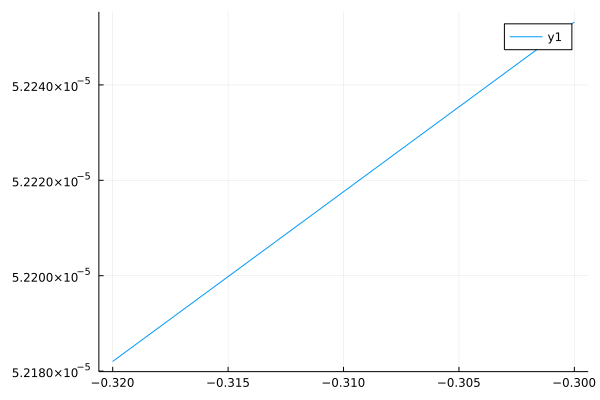

In [24]:
#plot(Ud1s, posuny)
#Pro ns = 1000
chyby1k = chyby
display(plot(Ud1s, chyby1k))
posuny1k = posuny
plot(Ud1s, posuny1k)

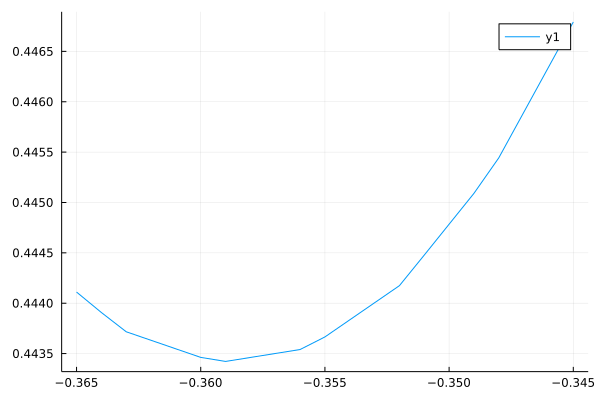

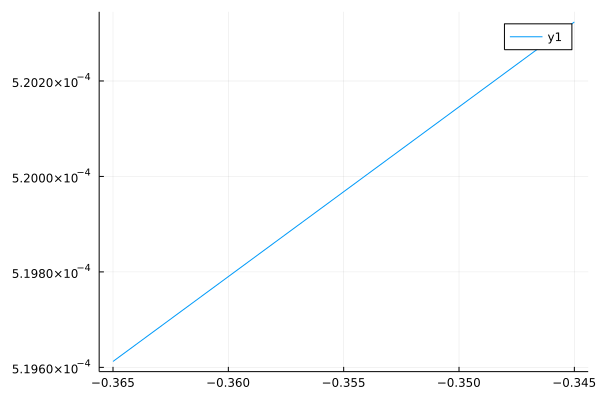

In [22]:
#Pro ns = 100
chyby100 = chyby
display(plot(Ud1s, chyby100))
posuny100 = posuny
plot(Ud1s, posuny100)

In [117]:
p=3
λ₁ = (p-1)*(2*(π/p)/(sin(π/p)))^p
println("Přesná hodnota λ₁ₚ=$λ₁")

n = 22
ns = 150000# 150000
si = mince(0..1,(n-1)*ns) # dělení splinu
λᵢₙᵢₜ = (3.,40.);

Ud1s = -0.00001:0.0000005:-0.000009
#Ud1s = [-π/10-0.00001 -π/10 -π/10+0.00001]

t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n, plt_res=false);
#Uₗd1 = - ceil(Λ₁) * 0.000522^(p-1)
#Uᵣd1 = - ceil(Λ₁) * 0.000522^(p-1)

posuny = []
chyby = []


for Ud1 in Ud1s 
    csc_U₂, U₂ˢ = cubic_end_slope_spline(t, tᴵ, U₂, U₂ᴵ, Ud1, Ud1, ns=ns, plt_res=false);
    U₁ˢ, posun = get_u1(p,U₂ˢ, t, U₁, plt_res=false);
    U₂ˢ_der = der_cubic_spline(csc_U₂, t, tᴵ, ns, plt_res=false);
    λ₁ˡᵒʷ, Fˡᵒʷ = lower_estimate(U₂ˢ_der, U₁ˢ, p, plt_res=false);
    append!(posuny, posun)
    append!(chyby, λ₁-λ₁ˡᵒʷ)
    #@show Ud1
    #println("Dolní odhad λ₁ˡᵒʷ=$λ₁ˡᵒʷ")
    #println("Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁-λ₁ˡᵒʷ)")
    #println("-----------------")
end

Přesná hodnota λ₁ₚ=28.28876197600255


In [119]:
chyby

3-element Vector{Any}:
 0.09184480373896875
 0.09184481017751267
 0.091844816616141856

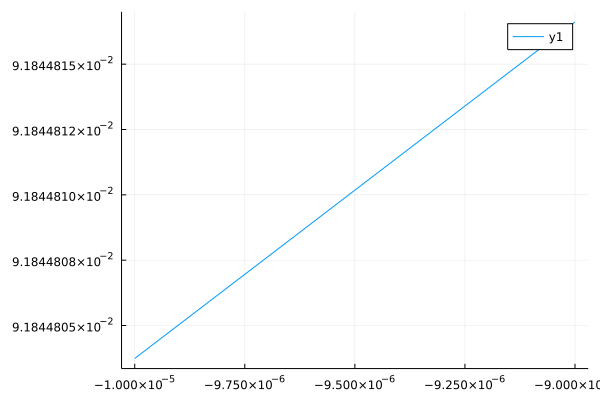

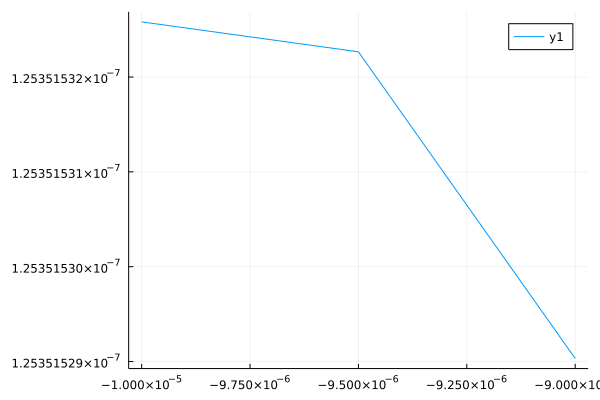

In [118]:
#Pro ns = 150000
chyby150kp3 = chyby
display(plot(Ud1s, chyby150kp3))
posuny150kp3 = posuny
plot(Ud1s, posuny150kp3)

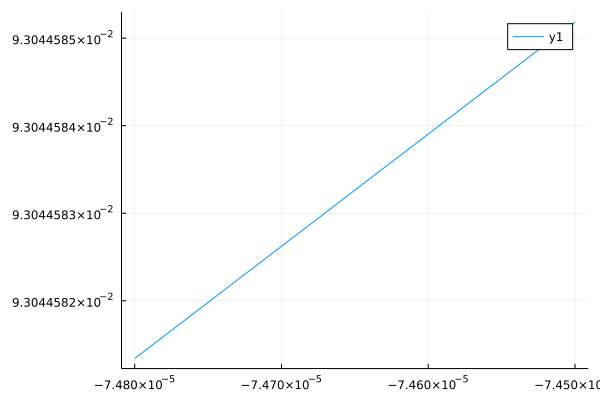

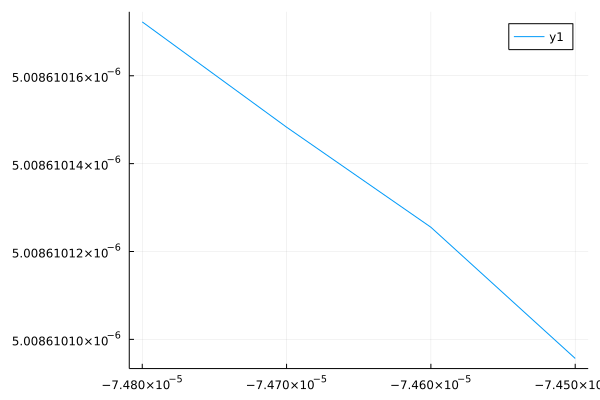

In [113]:
#Pro ns = 10000
chyby10kp3 = chyby
display(plot(Ud1s, chyby10kp3))
posuny10kp3 = posuny
plot(Ud1s, posuny10kp3)

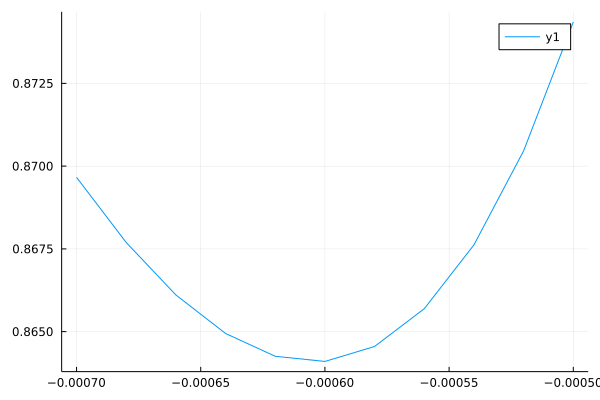

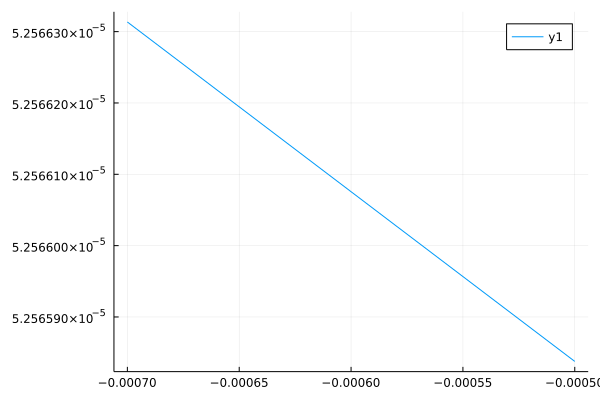

In [74]:
#Pro ns = 1000
chyby1kp3 = chyby
display(plot(Ud1s, chyby1kp3))
posuny1kp3 = posuny
plot(Ud1s, posuny1kp3)

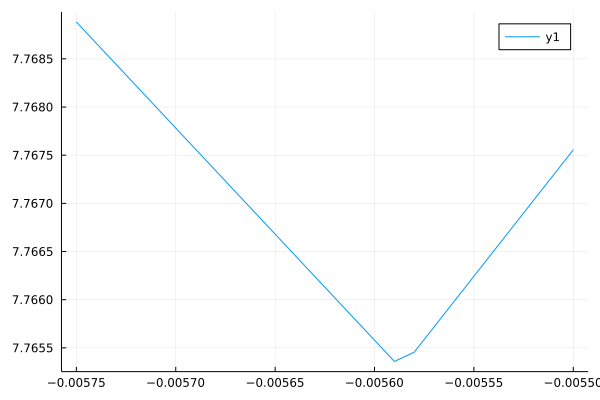

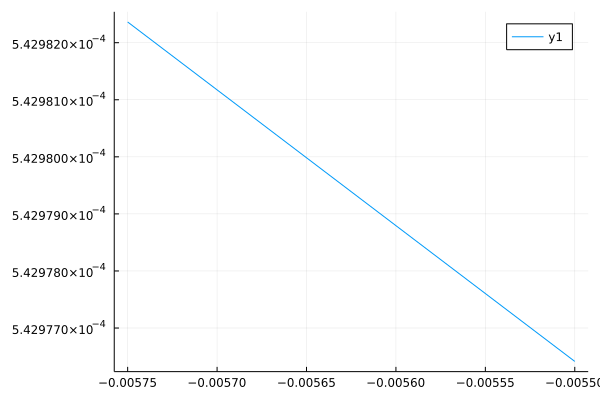

In [58]:
#Pro ns = 100
chyby100p3 = chyby
display(plot(Ud1s, chyby100p3))
posuny100p3 = posuny
plot(Ud1s, posuny100p3)

**Test na optimální počet oblouků splinu**

22 oblouků jako optimum zůstává

In [407]:
p=3
λ₁ = (p-1)*(2*(π/p)/(sin(π/p)))^p
println("Přesná hodnota λ₁ₚ=$λ₁")

#n = 22
NS = [10, 13, 15,17,19,20,21,22,23,24,28] #,32,40,50,80] 
ns = 1000# 150000

λᵢₙᵢₜ = (3.,40.);

Ud1 = -0.00045


posuny = []
chyby = []


for n in NS 
    si = mince(0..1,(n-1)*ns) # dělení splinu
    t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n, plt_res=false);
    csc_U₂, U₂ˢ = cubic_end_slope_spline(t, tᴵ, U₂, U₂ᴵ, Ud1, Ud1, ns=ns, plt_res=false);
    U₁ˢ, posun = get_u1(p,U₂ˢ, t, U₁, plt_res=false);
    U₂ˢ_der = der_cubic_spline(csc_U₂, t, tᴵ, ns, plt_res=false);
    λ₁ˡᵒʷ, Fˡᵒʷ = lower_estimate(U₂ˢ_der, U₁ˢ, p, plt_res=false);
    append!(posuny, posun)
    append!(chyby, λ₁-λ₁ˡᵒʷ)
    #@show Ud1
    #println("Dolní odhad λ₁ˡᵒʷ=$λ₁ˡᵒʷ")
    #println("Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁-λ₁ˡᵒʷ)")
    #println("-----------------")
end

Přesná hodnota λ₁ₚ=28.28876197600255


minimum(NS[argmin(chyby)]) = 22


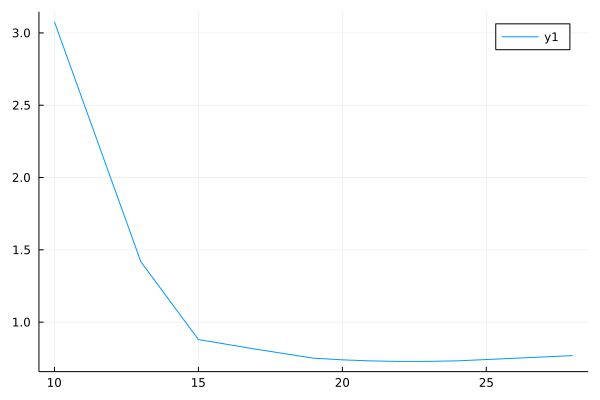

In [409]:
@show minimum(NS[argmin(chyby)])
plot(NS,chyby)

In [398]:
p=3
λ₁ = (p-1)*(2*(π/p)/(sin(π/p)))^p
println("Přesná hodnota λ₁ₚ: $λ₁")

n = 22
ns = 1000
si = mince(0..1,(n-1)*ns)
λᵢₙᵢₜ = (3.,40.); 

t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n, plt_res=false);
#p=3: vlevo= +0.01065 , vpravo=-0.03425
csc_U₂, U₂ˢ = cubic_end_slope_spline(t, tᴵ, U₂, U₂ᴵ, -0.00045, -0.00045, ns=ns, plt_res=false);

U₁ˢ, δ = get_u1(p,U₂ˢ, t, U₁, plt_res=false);
U₂ˢ_der = der_cubic_spline(csc_U₂, t, tᴵ, ns, plt_res=false);
λ₁ˡᵒʷ, Fˡᵒʷ = lower_estimate(U₂ˢ_der, U₁ˢ, p, plt_res=false);
println("Dolní odhad λ₁ˡᵒʷ=$λ₁ˡᵒʷ")
println("Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁-λ₁ˡᵒʷ)")

csc_U₁, U₁ˢ = cubic_natural_spline(t, tᴵ, U₁, U₁ᴵ, -1, -1, ns=ns, plt_res=false);
U₁ˢ_der = der_cubic_spline(csc_U₁, t, tᴵ, ns, plt_res=false); 
λ₁ᵘᵖ = upper_estimate(p, U₁ˢ, U₁ˢ_der, plt_res=false);
println("Horní odhad λ₁ᵘᵖ=$λ₁ᵘᵖ")
println("Chyba horního odhadu proti přesné hodnotě λ₁ₚ: $(λ₁ᵘᵖ-λ₁)")

Přesná hodnota λ₁ₚ: 28.28876197600255
Dolní odhad λ₁ˡᵒʷ=27.560437858255387
Chyba dolního odhadu proti přesné hodnotě λ₁ₚ: 0.72832411774716377
Horní odhad λ₁ᵘᵖ=28.313178660648152
Chyba horního odhadu proti přesné hodnotě λ₁ₚ: 0.024416684645601094


**Závislost dolního a horního odhadu na $p$**

1215.676567 seconds (10.85 G allocations: 338.884 GiB, 6.90% gc time)


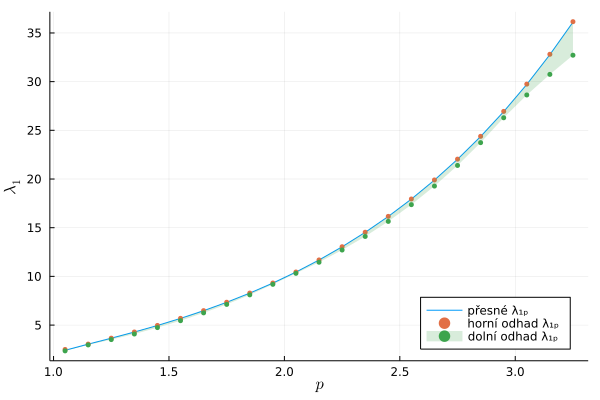

In [350]:
@time begin
    ps = 1.05:0.1:3.25
    #ps = 1.05:0.1:1.65

    n = 22 # kroků dělení
    ns = 1000 # dělení jednotlivého oblouku spline
    si = mince(0..1,(n-1)*ns) # dělení výsledného splinu

    λ₁s = []
    Λ₁s = []
    λ₁ˡᵒʷ = []
    abs_err_l1low = []
    δs
    λ₁ᵘᵖ = []
    
    Ud1s =  2.2 * -10 .^ -(0:0.1:3.6) #2.1 * -10 .^ -(0:0.25:5.25)

    for p in ps
        λ₁ = (p-1)*(2*(π/p)/(sin(π/p)))^p
        append!(λ₁s, λ₁)

        λᵢₙᵢₜ = (1.,λ₁s[end]+λ₁s[end]*0.5); 
        t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁ = plaplace_solve(λᵢₙᵢₜ, p, n, plt_res=false);
        append!(Λ₁s, Λ₁)
        
        #Ud1s = -0.05:0.00025:0
        err_tmp = []
        l1ls = []
        for Ud1 in Ud1s
            csc_U₂, U₂ˢ = cubic_end_slope_spline(t, tᴵ, U₂, U₂ᴵ, Ud1, Ud1, ns=ns, plt_res=false);

            #dolní odhad
            U₁ˢ, _ = get_u1(p,U₂ˢ, t, U₁, plt_res=false);
            U₂ˢ_der = der_cubic_spline(csc_U₂, t, tᴵ, ns, plt_res=false);
            l1low, δ = lower_estimate(U₂ˢ_der, U₁ˢ, p, plt_res=false);
            append!(err_tmp, λ₁-l1low)
            append!(l1ls, l1low)
            append!(δs, δ)
        end
        append!(abs_err_l1low, [err_tmp])
        append!(λ₁ˡᵒʷ, maximum(l1ls))
        
        #horní odhad
        csc_U₁, U₁ˢ = cubic_natural_spline(t, tᴵ, U₁, U₁ᴵ, -1, -1, ns=ns, plt_res=false);
        U₁ˢ_der = der_cubic_spline(csc_U₁, t, tᴵ, ns, plt_res=false); 
        l1up = upper_estimate(p, U₁ˢ, U₁ˢ_der, plt_res=false);
        append!(λ₁ᵘᵖ, l1up)
    end

    plot(ps, λ₁s, label="přesné λ₁ₚ")
    plot!(ps,λ₁ᵘᵖ, line = :scatter, msw = 0, ms = 3, label="horní odhad λ₁ₚ")
    plot!(ps,λ₁ˡᵒʷ, line = :scatter, msw = 0, ms = 3, 
        label="dolní odhad λ₁ₚ", fillrange = λ₁s, fillalpha = 0.2, 
        c = 3, legend=:bottomright, xlabel=L"p", ylabel=L"\lambda_1")
end

Závislost normované chyby dolního odhadu $\lambda_1$ na krajních hodnota prvních derivace $u_2$ při prokládání kubický splinem. 

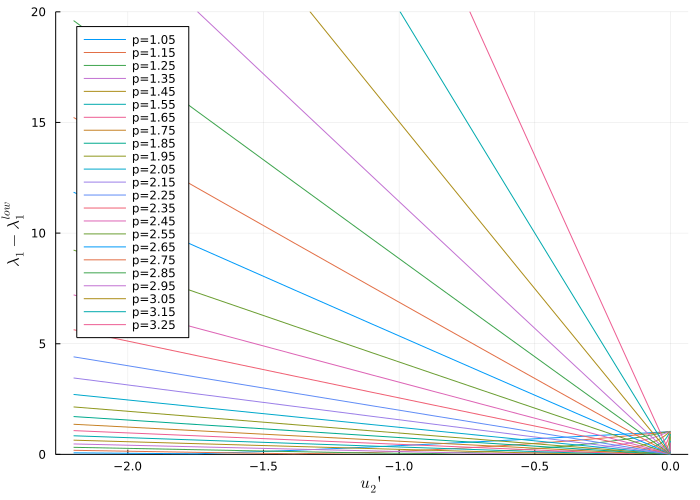

In [359]:
p_tmp = collect(ps)

plt = plot(0, ylim=(0,20), xlabel=L"u_2'", ylabel=L"\lambda_1 - \lambda_1^{low}", size=(700,500))
for i in 1:length(abs_err_l1low)
    plt = plot!(Ud1s, abs_err_l1low[i]/Λ₁s[i], label="p=$(p_tmp[i])", legend=:topleft)
end
display(plt)

Optimální hodnota $u_2'$ na krajích splinu v závislosti na "p".

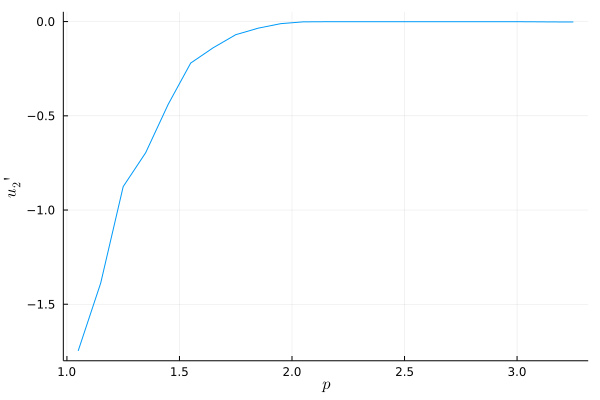

In [354]:
Ud1_optim = [Ud1s[argmin(abs_err_l1low[i])] for i in 1:length(abs_err_l1low)]
plot(ps, Ud1_optim, legend=false, xlabel=L"p", ylabel=L"u_2'")

In [355]:
hcat(ps, Ud1_optim)

23×2 Matrix{Float64}:
 1.05  -1.74752
 1.15  -1.38811
 1.25  -0.875836
 1.35  -0.695701
 1.45  -0.438958
 1.55  -0.22
 1.65  -0.138811
 1.75  -0.0695701
 1.85  -0.0348677
 1.95  -0.0110261
 2.05  -0.00138811
 2.15  -0.000695701
 2.25  -0.000552615
 2.35  -0.000552615
 2.45  -0.000552615
 2.55  -0.000552615
 2.65  -0.000552615
 2.75  -0.000552615
 2.85  -0.000552615
 2.95  -0.000552615
 3.05  -0.000875836
 3.15  -0.00174752
 3.25  -0.0022

Relativní chyba dolního odhadu $\lambda_1$ v závislosti na $p$

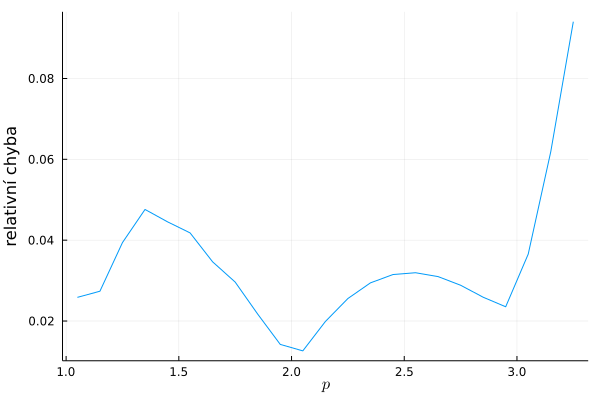

In [360]:
#ch_min = [minimum(abs_err_l1low[i]) for i in 1:length(abs_err_l1low)]
#Λ₁s = λ₁s-ch_min
rel_err = (λ₁s-λ₁ˡᵒʷ)./λ₁s

plot(ps, rel_err, xlabel=L"p", ylabel="relativní chyba", legend=false)

$p$ - skutečná hodnota $\lambda_1$ - dolní odhad $\lambda_1^{low}$ - horní odhad $\lambda_1^{up}$ - optimální $u_2'$ na krajích splinu

In [365]:
hcat(ps, λ₁s, λ₁ˡᵒʷ, λ₁ᵘᵖ, Ud1_optim)

23×5 Matrix{Any}:
 1.05   2.41454   2.35213   2.49851  -1.74752
 1.15   3.04668   2.96329   3.04976  -1.38811
 1.25   3.65598   3.51192   3.65815  -0.875836
 1.35   4.28832   4.08421   4.29029  -0.695701
 1.45   4.96229   4.74131   4.96427  -0.438958
 1.55   5.68978   5.45199   5.69187  -0.22
 1.65   6.48035   6.25591   6.4826   -0.138811
 1.75   7.34273   7.12517   7.34518  -0.0695701
 1.85   8.28549   8.10571   8.28818  -0.0348677
 1.95   9.31738   9.18499   9.32035  -0.0110261
 2.05  10.4476   10.3158   10.4509   -0.00138811
 2.15  11.6858   11.4536   11.6896   -0.000695701
 2.25  13.0426   12.7092   13.0469   -0.000552615
 2.35  14.529    14.1013   14.5341   -0.000552615
 2.45  16.1572   15.6483   16.1634   -0.000552615
 2.55  17.9402   17.3671   17.948    -0.000552615
 2.65  19.8922   19.2758   19.9022   -0.000552615
 2.75  22.0286   21.3931   22.0414   -0.000552615
 2.85  24.366    23.7352   24.3825   -0.000552615
 2.95  26.9224   26.2892   26.9438   -0.000552615
 3.05  29.7174  